In [3]:
# > run inference

In [26]:
import os, sys, time
sys.path.append("/Users/wvw/git/pm/pqn/convert") # (convert code)
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from convert_dfg import convert_rdf_dfg

def run(folder, norm_file, disc_file):
    norm_path = f"data/{folder}/{norm_file}.n3"
    disc_path = f"data/{folder}/{disc_file}.n3"
    prefix = folder.replace('/', '_')
    norm_closure_path = f"data/out/{prefix}_{norm_file}_closure.n3"
    # out_path = f"data/out/{prefix}_{norm_file}_{disc_file}.n3"
    out_path = f"data/out/{prefix}_{disc_file}.n3"
    
    start0 = time.time()
    if not os.path.isfile(norm_closure_path):
        print("getting closure first")
        start = time.time()
        os.system(f"eye utils.n3 rules-closure.n3 --turtle {norm_path} --nope --pass-only-new > {norm_closure_path} 2>/dev/null")
        end = time.time()
        print("closure time:", (end - start), "(s)")
    os.system(f"eye utils.n3 rules-princ.n3 --turtle {norm_path} {norm_closure_path} {disc_path} --pass-only-new > {out_path} 2>/dev/null")
    end0 = time.time()
    print("infer time:", (end0 - start0), "(s)")
    
    return out_path

infer time: 0.051796913146972656 (s)
conversion time (ms): 0.978


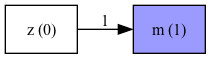

In [34]:
# - run test

# -- misc tests
outfile = run("tests", "test6-norm", "test6-disc1")

# -- tc - all
# nr = 0
# outfile = run("tc/all", "norm", f"diff-{nr}")

# -- tc - misc tests
# folder = "tc/1"
# outfile = f"data/out/{folder.replace('/', '_')}.n3"
# os.system(f"eye utils.n3 rules-princ.n3 --turtle ./data/{folder}/disc.n3 ./data/{folder}/norm.n3 --pass-only-new > {outfile}")  

# - visualize inferred links
dfg = convert_rdf_dfg(outfile, "")
# print(dfg)
dfg_visualizer.view(dfg_visualizer.apply(dfg))

In [1]:
# > create normative & diff RDF files

folder = "tc/all"

In [2]:
# - compare discovered with normative model
# (& store result as DFG, i.e., .py file)

import sys
sys.path.append("/Users/wvw/git/pm/compare_logs") # (compare code)
from modules.cmp_logs_v2 import compare_nodes_edges_dfg
from modules.utils import read_dict 

# read discovered, normative models
disc = read_dict(f"./data/{folder}/disc.py")
norm = read_dict(f"./data/{folder}/norm.py")

# compare models
_, node_diff, edge_diff = compare_nodes_edges_dfg([ disc, norm ])
# get edges that are missing in normative model
inconsist_edges = edge_diff[edge_diff['dfg_i']==0]

In [3]:
# - convert to RDF

sys.path.append("/Users/wvw/git/pm/pqn/convert") # (convert code)
from convert_dfg import convert_dfg_rdf, DFGSource
from rdflib import Namespace

TC = Namespace("http://canada.org/tc#")

In [ ]:
# convert normative model into RDF
convert_dfg_rdf(norm, f"./data/{folder}/norm.n3", TC, DFGSource.NORMATIVE)

In [ ]:
# convert each missing edge into RDF

for index, row in inconsist_edges.iterrows():
    diff = { ( row['src'], row['tgt'] ): 1 }
    
    # with open(f"./data/tc/all/diff-{index}.py", 'w') as f:
    #     f.write(str(dict))
    
    convert_dfg_rdf(diff, f"../infer/data/{folder}/diff-{index}.n3", TC, DFGSource.DISCOVERED)

In [ ]:
import re

f1 = "data/out/tc_all_norm_diff-0.n3"
f2 = "data/out/tmp.n3"

lines1 = open(f1).read().split("\n")
invalidated1 = [ re.findall("(.*) dfg:invalidated", line)[0] for line in lines1 if "dfg:invalidated" in line ]
print("invalidated1:", invalidated1)

lines2 = open(f2).read().split("\n")
invalidated2 = [ re.findall("(.*) dfg:invalidated", line)[0] for line in lines2 if "dfg:invalidated" in line ]
print("invalidated2:", invalidated2)

notin1 = [ inv for inv in invalidated2 if inv not in invalidated1 ]
print("notin1:", notin1)

notin2 = [ inv for inv in invalidated1 if inv not in invalidated2 ]
print("notin2:", notin2)